# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```
## What is expected?

* Complete and run the code using `jupyter-lab`.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* If Jupyter complains issues during exporting, it is likely that [pandoc](https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry. Alternatively, use the Print function of your browser to export the PDF file.

* If Jupyter-lab does not work for you at the end, alternatively, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [7]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Q1. Download and visualise the imaging dataset.

The dataset is a public brain imaging dataset from [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from the original 3D volumes (T1-Gd contrast enhanced imaging) and downsample the 2D images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [8]:
# Download the dataset
# If you use Ubuntu, wget would natively work.
# If you use Mac or Windows, which does not have the wget command, you can copy the URL to the web browser and download the file.
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2026-02-08 20:37:20--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1 [following]
--2026-02-08 20:37:20--  https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45d2af359995bb21704e0488df.dl.dropboxusercontent.com/cd/0/inline/C6i1WaWQ9rKTEtuo3_4wBzboWQc_geaRxzi6h85BiI4jHa9kGCqB1mXegUg0agGBBIOi8fr4opmXcIKUHDPrqAvfj90ZWvoJQ3Slb_PDwLneuZAdWnSV7yARcNJSU1QTwng/file# [following]
--2026-02-08 20:37:20--  https://uc45d2af359995bb21704e0488df.dl.dropbo

/tmp/ipython-input-455641098.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  datafile.extractall()


## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

num training images: 2028
num training labels: 2028
example: BRATS_001_z108.png BRATS_001_z108.png


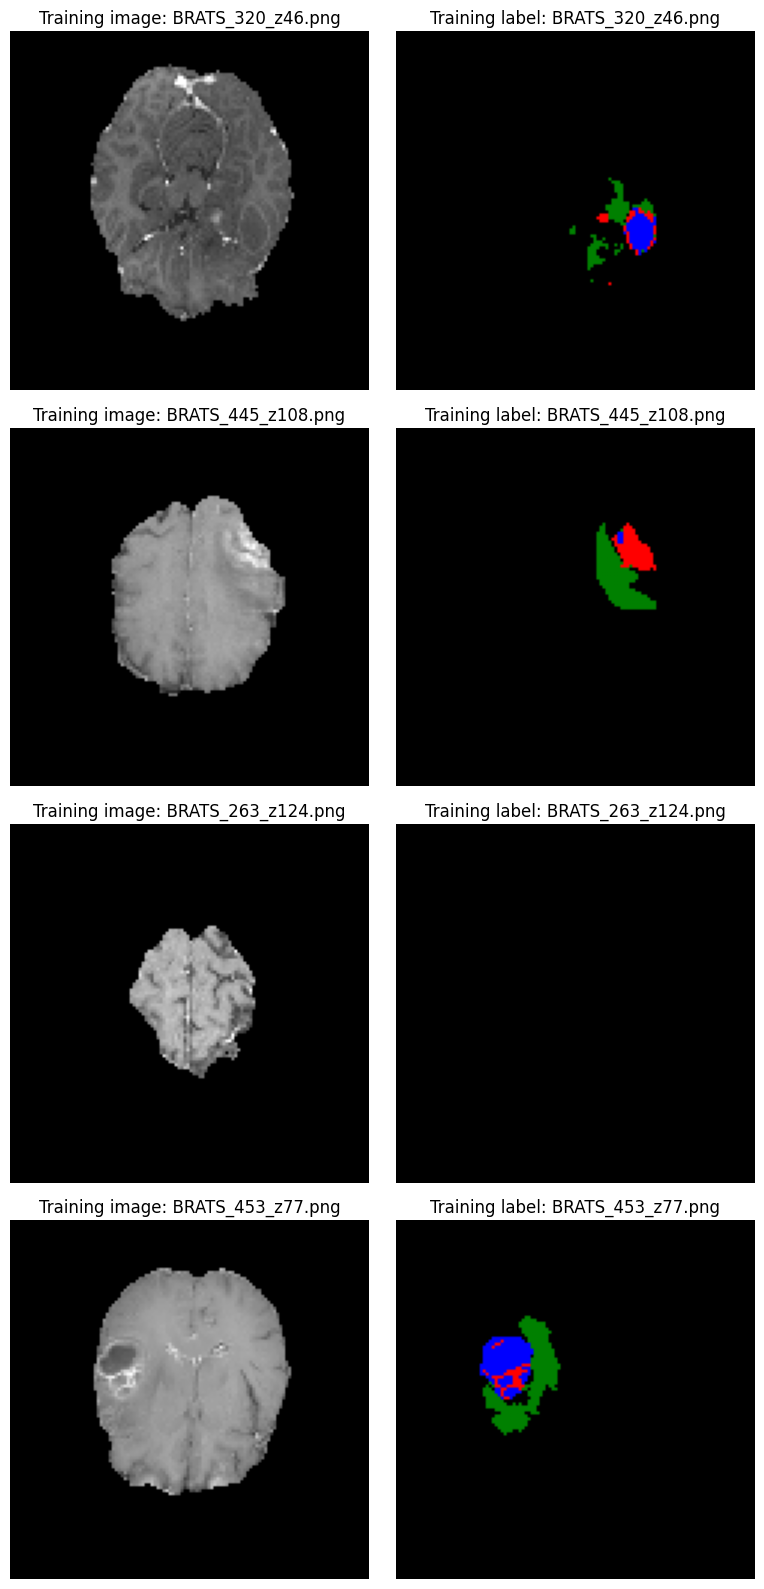

Unique label values in these 4 samples:
BRATS_320_z46.png -> [0 1 2 3]
BRATS_445_z108.png -> [0 1 2 3]
BRATS_263_z124.png -> [0]
BRATS_453_z77.png -> [0 1 2 3]


In [9]:
root = "Task01_BrainTumour_2D"
images_tr_dir = os.path.join(root, "training_images")
labels_tr_dir = os.path.join(root, "training_labels")


image_files = sorted([f for f in os.listdir(images_tr_dir) if f.endswith(".png")])
label_files = sorted([f for f in os.listdir(labels_tr_dir) if f.endswith(".png")])

print("num training images:", len(image_files))
print("num training labels:", len(label_files))
print("example:", image_files[0], label_files[0])

N = 4
idxs = random.sample(range(len(image_files)), N)


seg_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, axes = plt.subplots(N, 2, figsize=(8, 4*N))

for row, idx in enumerate(idxs):
    img_path = os.path.join(images_tr_dir, image_files[idx])
    lab_path = os.path.join(labels_tr_dir, label_files[idx])

    img = imageio.v2.imread(img_path)
    lab = imageio.v2.imread(lab_path)

    axes[row, 0].imshow(img, cmap="gray")
    axes[row, 0].set_title(f"Training image: {image_files[idx]}")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(lab, cmap=seg_cmap, vmin=0, vmax=3)
    axes[row, 1].set_title(f"Training label: {label_files[idx]}")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()


print("Unique label values in these 4 samples:")
for idx in idxs:
    lab = imageio.v2.imread(os.path.join(labels_tr_dir, label_files[idx]))
    print(label_files[idx], "->", np.unique(lab))

## Q2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, to be used as training batches.

In [10]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v2.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v2.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []


        if batch_size <= len(self):
            idxs = random.sample(range(len(self)), batch_size)
        else:
            idxs = [random.randrange(len(self)) for _ in range(batch_size)]

        for idx in idxs:
            img, lab = self[idx]              # img: XY (float), lab: XY (int)
            images.append(img[np.newaxis, ...])# 变成 1XY，之后 stack 得到 N1XY
            labels.append(lab)                 # 维持 XY

        images = np.stack(images, axis=0).astype(np.float32)  # N,1,X,Y
        labels = np.stack(labels, axis=0).astype(np.int64)    # N,X,Y

        return images, labels

## Q3. Build a U-net architecture.

Implement a U-net architecture for image segmentation. If you are not familiar with U-net, you can read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [11]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path


        self.up3 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)  # 128 -> 64
        self.dec3 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),   # (64+64)=128 -> 64
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU()
        )
        n //= 2

        self.up2 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)  # 64 -> 32
        self.dec2 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),   # (32+32)=64 -> 32
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU()
        )
        n //= 2

        self.up1 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)  # 32 -> 16
        self.dec1 = nn.Sequential(
            nn.Conv2d(n, n // 2, kernel_size=3, padding=1),   # (16+16)=32 -> 16
            nn.BatchNorm2d(n // 2),
            nn.ReLU(),
            nn.Conv2d(n // 2, n // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(n // 2),
            nn.ReLU()
        )
        n //= 2  # n = 16


        self.out = nn.Conv2d(n, output_channel, kernel_size=1)


    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        x = self.up3(x)                              # upsample to match conv3
        x = torch.cat([x, conv3_skip], dim=1)        # concat on channel dim
        x = self.dec3(x)

        x = self.up2(x)                              # match conv2
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.dec2(x)

        x = self.up1(x)                              # match conv1
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.dec1(x)

        x = self.out(x)
        return x

## Q4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)


    loss = criterion(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print training loss occasionally
    if it % 100 == 0:
        print(f"Iter {it}/{num_iter} | train loss = {loss.item():.4f} | iter time = {time.time()-start_iter:.3f}s")


    # Evaluate
    if it % 1000 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            images_t, labels_t = test_set.get_random_batch(eval_batch_size)
            images_t, labels_t = torch.from_numpy(images_t), torch.from_numpy(labels_t)
            images_t = images_t.to(device, dtype=torch.float32)
            labels_t = labels_t.to(device, dtype=torch.long)

            logits_t = model(images_t)
            loss_t = criterion(logits_t, labels_t)
            print(f"Iter {it}/{num_iter} | test loss = {loss_t.item():.4f}")


    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iter 100/10000 | train loss = 0.3145 | iter time = 0.056s
Iter 200/10000 | train loss = 0.1233 | iter time = 0.057s
Iter 300/10000 | train loss = 0.0865 | iter time = 0.056s
Iter 400/10000 | train loss = 0.0647 | iter time = 0.055s
Iter 500/10000 | train loss = 0.0487 | iter time = 0.056s
Iter 600/10000 | train loss = 0.0609 | iter time = 0.057s
Iter 700/10000 | train loss = 0.0504 | iter time = 0.058s
Iter 800/10000 | train loss = 0.0461 | iter time = 0.058s
Iter 900/10000 | train loss = 0.0412 | iter time = 0.058s
Iter 1000/10000 | train loss = 0.0609 | iter time = 0.059s
Iter 1000/10000 | test loss = 0.0642
Iter 1100/10000 | train loss = 0.0403 | iter time = 0.056s
Iter 1200/10000 | train loss = 0.0449 | iter time = 0.055s
Iter 1300/10000 | train loss = 0.0316 | iter time = 0.059s
Iter 1400/10000 | train loss = 0.0315 | iter time = 0.059s
Iter 1500/10000 | train loss = 0.0364 | iter time = 0.059s
Iter 1600/10000 | train loss = 0.0334 | iter time = 0.059s
Iter 1700/10000

## Q5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors

seg_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

model.eval()

N = 4
idxs = random.sample(range(len(test_set)), N)

fig, axes = plt.subplots(N, 3, figsize=(12, 4*N))

with torch.no_grad():
    for row, idx in enumerate(idxs):

        img_np, gt_np = test_set[idx]


        x = torch.from_numpy(img_np[np.newaxis, np.newaxis, ...]).to(device, dtype=torch.float32)


        logits = model(x)                     # (1,4,120,120)
        pred = torch.argmax(logits, dim=1)    # (1,120,120)
        pred_np = pred.squeeze(0).cpu().numpy()


        axes[row, 0].imshow(img_np, cmap='gray')
        axes[row, 0].set_title("Test image")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(pred_np, cmap=seg_cmap, vmin=0, vmax=3)
        axes[row, 1].set_title("Automated segmentation")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(gt_np, cmap=seg_cmap, vmin=0, vmax=3)
        axes[row, 2].set_title("Ground truth")
        axes[row, 2].axis("off")

plt.tight_layout()
plt.show()


## Q6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?